## Output Probabilities for all subjects and ROC curve inputs for some kind of statistical anlysis of ROC curves

From request [ROC Output and Probabilities](https://trello.com/c/JcZRCXte)

## Imports and Function Definitions

In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    print("TRAINNG PROBABILITIES")
    for a,b in zip(y, clf.predict_proba(X)[:,1]):
        print(a,b)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    print("TESTING PROBABILITIES")
    for a,b in zip(Y_test,y_pred_prob):
        print(a,b)
    
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))
        
def print_score_summaries(scores_dict):
    for score_name in scores_dict:
        scores = scores_dict[score_name]
        print("%s\t%s\t%s" %(score_name, np.mean(scores[~np.isnan(scores)]), np.std(scores[~np.isnan(scores)])))

## Define classifier, pipeline and constants

In [5]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('Data_no_UM.xlsx').drop(['UPDRS'], axis=1)
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.5s finished


Best parameters set found on development set:

{'classifier__C': 0.061584821106602607}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.34      0.72      0.46        36
          1       0.88      0.59      0.71       124

avg / total       0.76      0.62      0.65       160


Confusion matrix, without normalization
[[26 10]
 [51 73]]

recall	0.588709677419
precision	0.879518072289
auc	0.655465949821
specificity	0.722222222222
npv	0.337662337662
accuracy	0.61875
weighted_sensitivity	0.588709677419
weighted_ppv	0.679420889349
weighted_specificity	0.722222222222
weighted_npv	0.637154150198
weighted_accuracy	0.655465949821
TRAINNG PROBABILITIES
1 0.696203685209
1 0.937689407937
0 0.582198201731
1 0.777961383113
0 0.792400366091
1 0.722403105135
1 0.663315592511
1 0.943440238028
1 0.869987970623
0 0.5
1 0.569579281986
1 

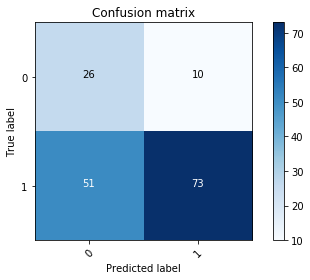

In [6]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [7]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
print_score_summaries(scores)

fit_time	0.170812797546	0.00424311212317
score_time	0.0799185752869	0.00491105049862
test_recall	0.627659574468	0.0242590515979
train_recall	0.71914893617	0.0163601664885
test_precision	0.862653640867	0.0187726280525
train_precision	0.926110285043	0.00447410672909
test_auc	0.672029430728	0.0268292864608
train_auc	0.778263235458	0.00540518291702
test_specificity	0.716399286988	0.0433283432785
train_specificity	0.837377534746	0.0127899532652
test_npv	0.404894766562	0.0248452252987
train_npv	0.5133030673	0.0123929780159
test_accuracy	0.650898129921	0.02321438392
train_accuracy	0.749993812168	0.00990154079105
test_weighted_sensitivity	0.627659574468	0.0242590515979
train_weighted_sensitivity	0.71914893617	0.0163601664885
test_weighted_ppv	0.690059536004	0.0368225206719
train_weighted_ppv	0.815811032123	0.00953549814041
test_weighted_specificity	0.716399286988	0.0433283432785
train_weighted_specificity	0.837377534746	0.0127899532652
test_weighted_npv	0.657754664064	0.0212273204233
train_wei

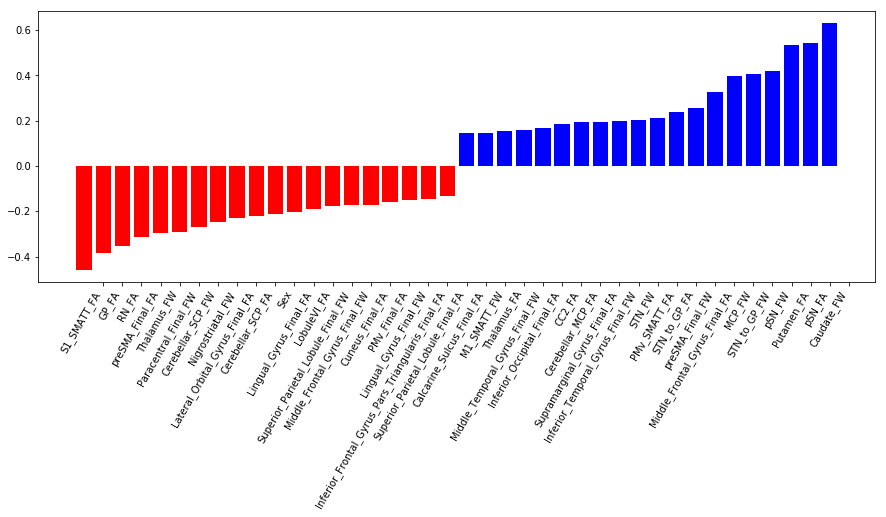

Age	0.0774054996274
Sex	-0.210464444617
aSN_FA	-0.120557910666
Caudate_FA	0.0575337726754
CC2_FA	0.185396868713
GP_FA	-0.384627701388
LobuleVI_FA	-0.18963626248
LobuleV_FA	-0.0341472518206
MCP_FA	-0.0901329012505
pSN_FA	0.543750208132
Putamen_FA	0.533531297404
SCP_FA	-0.0482025568326
STN_FA	-0.0200792926537
Thalamus_FA	0.155675298939
Vermis_FA	-0.00412488451735
RN_FA	-0.351274692412
PPN_FA	0.0685982572201
Dentate_FA	0.0644811266414
CC1_FA	-0.0870384580533
aSN_FW	-0.0977929251903
Caudate_FW	0.632158637637
CC2_FW	0.0430917036403
GP_FW	-0.0687846786745
LobuleVI_FW	-0.0251672115725
LobuleV_FW	-0.122564547721
MCP_FW	0.395583255786
pSN_FW	0.419943984247
Putamen_FW	0.0612856180528
SCP_FW	0.0701776740461
STN_FW	0.204927687327
Thalamus_FW	-0.295465360106
Vermis_FW	-0.00112467657895
RN_FW	0.127513563226
PPN_FW	0.114132272698
Dentate_FW	0.0500493090864
CC1_FW	0.0615892992508
Angular_Gyrus_Final_FA	-0.0615379792767
Anterior_Orbital_Gyrus_Final_FA	0.100040153096
Calcarine_Sulcus_Final_FA	0.14560662

In [8]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.34      0.72      0.46        36
          1       0.88      0.59      0.71       124

avg / total       0.76      0.62      0.65       160

TESTING PROBABILITIES
0 0.798771145606
1 0.957633251831
1 0.71854643337
1 0.941174546771
1 0.795828600683
1 0.953206960772
1 0.412805356904
1 0.747356360605
0 0.659543288553
0 0.680070520348
1 0.65325635872
1 0.971051480292
1 0.522791885023
1 0.838750812289
1 0.842759418438
1 0.808242590017
1 0.83182582708
0 0.568987414316
1 0.776853257757
1 0.489650541459
0 0.705877234945
1 0.719358896663
0 0.827024246492
1 0.628748544478
1 0.78869123739
1 0.848102586391
0 0.681401838174
0 0.365859242987
1 0.706431518174
0 0.429409105447
1 0.70495094882
1 0.820124866773
1 0.88913512385
1 0.591097726458
1 0.569275137831
0 0.787078880878
1 0.60927239295
1 0.715819830398
1 0.757864760337
1 0.621206142078
1 0.681972355551
0 0.491302113275
0 0.74677919117
1 0.841086332653
0 0.814717603031
1 0.92

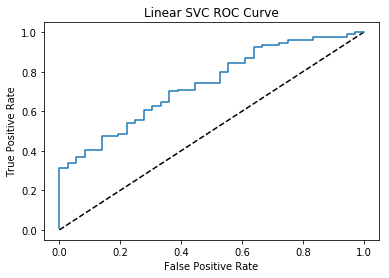

0.0 0.00806451612903
0.0 0.314516129032
0.0277777777778 0.314516129032
0.0277777777778 0.338709677419
0.0555555555556 0.338709677419
0.0555555555556 0.370967741935
0.0833333333333 0.370967741935
0.0833333333333 0.403225806452
0.138888888889 0.403225806452
0.138888888889 0.475806451613
0.194444444444 0.475806451613
0.194444444444 0.483870967742
0.222222222222 0.483870967742
0.222222222222 0.540322580645
0.25 0.540322580645
0.25 0.556451612903
0.277777777778 0.556451612903
0.277777777778 0.604838709677
0.305555555556 0.604838709677
0.305555555556 0.629032258065
0.333333333333 0.629032258065
0.333333333333 0.645161290323
0.361111111111 0.645161290323
0.361111111111 0.701612903226
0.388888888889 0.701612903226
0.388888888889 0.709677419355
0.444444444444 0.709677419355
0.444444444444 0.741935483871
0.527777777778 0.741935483871
0.527777777778 0.798387096774
0.555555555556 0.798387096774
0.555555555556 0.846774193548
0.611111111111 0.846774193548
0.611111111111 0.870967741935
0.638888888889

In [9]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.0s finished


Best parameters set found on development set:

{'classifier__C': 0.0069519279617756054}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.92      0.99      0.95        82
          1       0.97      0.81      0.88        37

avg / total       0.94      0.93      0.93       119


Confusion matrix, without normalization
[[81  1]
 [ 7 30]]

recall	0.810810810811
precision	0.967741935484
auc	0.89930784443
specificity	0.987804878049
npv	0.920454545455
accuracy	0.932773109244
weighted_sensitivity	0.810810810811
weighted_ppv	0.985182218662
weighted_specificity	0.987804878049
weighted_npv	0.839260711285
weighted_accuracy	0.89930784443
TRAINNG PROBABILITIES
0 0.0330777424424
0 0.107573627743
0 0.280753567755
0 0.0937563734351
0 0.25766507257
0 0.0336041874436
1 0.989522334611
0 0.0346822061495
0 0.223264397031
0 0.107558584387

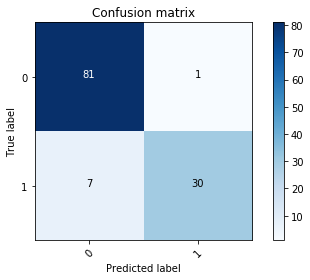

In [10]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [11]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0865015506744	0.0168594396239
score_time	0.0498015403748	0.0139492189745
test_recall	0.727301587302	0.0222765775147
train_recall	0.789807497467	0.0205283192333
test_precision	0.904762036052	0.0573415262325
train_precision	0.923753714291	0.0109932853587
test_auc	0.84028921173	0.019017889706
train_auc	0.875674320561	0.00962545512775
test_specificity	0.953276836158	0.0304951843829
train_specificity	0.961541143654	0.00613073440839
test_npv	0.855886597164	0.0111856315404
train_npv	0.886116054165	0.00965701582065
test_accuracy	0.869468551698	0.0206380204174
train_accuracy	0.897904136966	0.00718476986129
test_weighted_sensitivity	0.727301587302	0.0222765775147
train_weighted_sensitivity	0.789807497467	0.0205283192333
test_weighted_ppv	0.941033531513	0.0366806302539
train_weighted_ppv	0.953647653608	0.00678750710261
test_weighted_specificity	0.953276836158	0.0304951843829
train_weighted_specificity	0.961541143654	0.00613073440839
test_weighted_npv	0.777685544186	0.0157773287855
trai

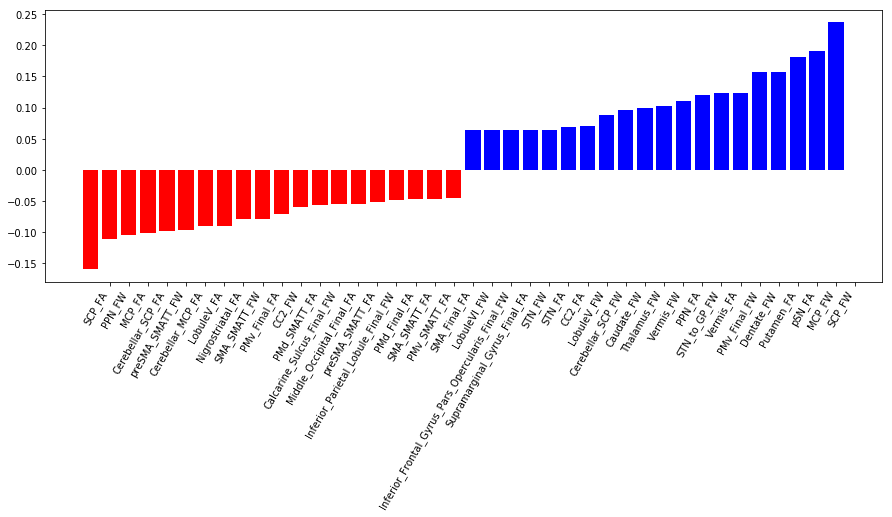

Age	0.0318300360207
Sex	0.0
aSN_FA	0.0256626650557
Caudate_FA	0.0175241837159
CC2_FA	0.069159139761
GP_FA	-0.0442930562358
LobuleVI_FA	0.0466440588113
LobuleV_FA	-0.0910948040781
MCP_FA	-0.10407006984
pSN_FA	0.181170183223
Putamen_FA	0.157072234225
SCP_FA	-0.159862350105
STN_FA	0.0644152149421
Thalamus_FA	0.038959104598
Vermis_FA	0.123084694131
RN_FA	-0.0228313204432
PPN_FA	0.110147647767
Dentate_FA	-0.00648535313782
CC1_FA	-0.0378905440265
aSN_FW	0.00642626485579
Caudate_FW	0.0966276828985
CC2_FW	-0.0704827610918
GP_FW	0.0107053413955
LobuleVI_FW	0.0631668504377
LobuleV_FW	0.0701803703161
MCP_FW	0.190472136613
pSN_FW	-0.0277813090394
Putamen_FW	0.0119900909767
SCP_FW	0.237262692175
STN_FW	0.0642965940621
Thalamus_FW	0.0985851837322
Vermis_FW	0.101847077858
RN_FW	0.0190762132007
PPN_FW	-0.110794423534
Dentate_FW	0.156699005141
CC1_FW	0.00802513517722
Angular_Gyrus_Final_FA	-0.0119962103379
Anterior_Orbital_Gyrus_Final_FA	0.0435016940193
Calcarine_Sulcus_Final_FA	-0.0283342993898
Cuneus

In [12]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.92      0.99      0.95        82
          1       0.97      0.81      0.88        37

avg / total       0.94      0.93      0.93       119

TESTING PROBABILITIES
0 0.0616488246154
0 0.0491426589038
1 0.865296392145
0 0.10070311675
1 0.412097821676
0 0.0894048085108
0 0.0962284078198
1 0.873723321843
0 0.0945722224049
1 0.840879614528
0 0.0298733035817
0 0.222781129254
1 0.918767402015
0 0.0225820754697
0 0.295864744882
1 0.0573288667009
1 0.885888416534
0 0.270426694919
1 0.831968353142
1 0.923173107839
1 0.906200441171
1 0.909280795372
0 0.0345017395047
0 0.134093453439
0 0.147673910863
0 0.0958370589644
1 0.993741630527
0 0.0356649838652
1 0.993001720713
0 0.037999221564
0 0.0782231649548
0 0.0442945497761
0 0.144471956916
0 0.074991444721
1 0.726884796711
0 0.0756136962003
0 0.0384003760528
1 0.958246280919
0 0.0775877395499
0 0.143175002606
1 0.581211342617
0 0.0400988704172
1 0.171972606321
1 0.983439802995

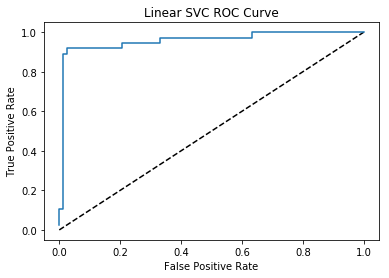

0.0 0.027027027027
0.0 0.108108108108
0.0121951219512 0.108108108108
0.0121951219512 0.891891891892
0.0243902439024 0.891891891892
0.0243902439024 0.918918918919
0.207317073171 0.918918918919
0.207317073171 0.945945945946
0.329268292683 0.945945945946
0.329268292683 0.972972972973
0.634146341463 0.972972972973
0.634146341463 1.0
1.0 1.0


In [13]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


Best parameters set found on development set:

{'classifier__C': 0.0033598182862837811}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       107
          1       0.67      0.67      0.67        12

avg / total       0.93      0.93      0.93       119


Confusion matrix, without normalization
[[103   4]
 [  4   8]]

recall	0.666666666667
precision	0.666666666667
auc	0.814641744548
specificity	0.96261682243
npv	0.96261682243
accuracy	0.932773109244
weighted_sensitivity	0.666666666667
weighted_ppv	0.946902654867
weighted_specificity	0.96261682243
weighted_npv	0.742788461538
weighted_accuracy	0.814641744548
TRAINNG PROBABILITIES
0 0.068683760147
0 0.143474044998
0 0.0669646062755
0 0.0442134612357
0 0.0534044120081
0 0.0185958325329
0 0.0815674267651
0 0.0843006940856
0 0.0529143122634
0 0.05494

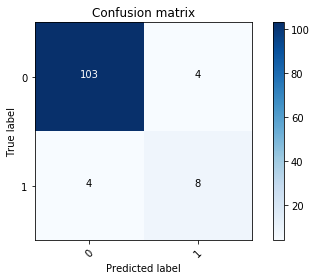

In [14]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [15]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0886375427246	0.00392207351227
score_time	0.0483120441437	0.00364799885948
test_recall	0.55619047619	0.0974691066819
train_recall	0.659891107078	0.0235123553404
test_precision	0.601318681319	0.0935900231532
train_precision	0.692610634648	0.0464464179883
test_auc	0.744592151675	0.052019791825
train_auc	0.803265362012	0.00909310077948
test_specificity	0.93299382716	0.0216288227765
train_specificity	0.946639616945	0.0138388213254
test_npv	0.921839093061	0.0164876020613
train_npv	0.939703331523	0.00375689475696
test_accuracy	0.87577920866	0.0252855865384
train_accuracy	0.903147656293	0.00973969375244
test_weighted_sensitivity	0.55619047619	0.0974691066819
train_weighted_sensitivity	0.659891107078	0.0235123553404
test_weighted_ppv	0.890247928579	0.0364795883083
train_weighted_ppv	0.925778682559	0.0156863766985
test_weighted_specificity	0.93299382716	0.0216288227765
train_weighted_specificity	0.946639616945	0.0138388213254
test_weighted_npv	0.680763160242	0.0483098312398
train_wei

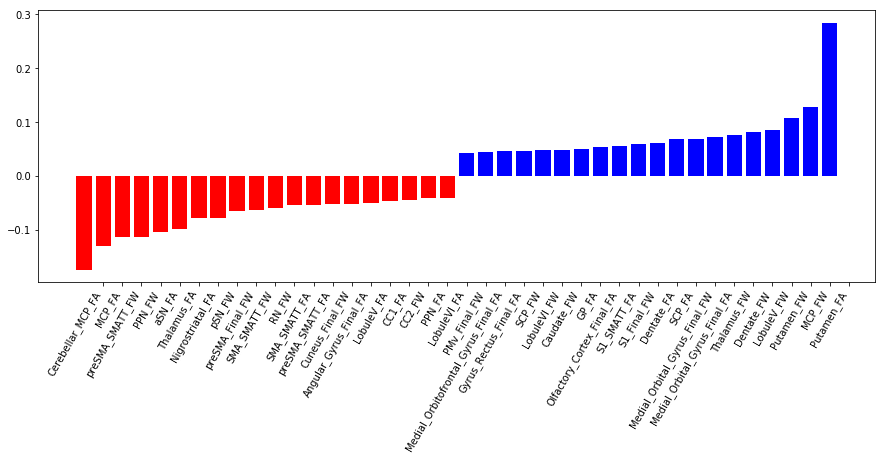

Age	0.0198922823981
Sex	0.0
aSN_FA	-0.104357627333
Caudate_FA	-0.0198019190031
CC2_FA	0.0406341349824
GP_FA	0.0501543918295
LobuleVI_FA	-0.0413267926406
LobuleV_FA	-0.0505024181725
MCP_FA	-0.130385552935
pSN_FA	0.0335913869404
Putamen_FA	0.28489392996
SCP_FA	0.0675989365767
STN_FA	-0.0271990555223
Thalamus_FA	-0.0979948290189
Vermis_FA	0.0148037953313
RN_FA	-0.0241611258199
PPN_FA	-0.0415306503411
Dentate_FA	0.0606428825063
CC1_FA	-0.0470572666847
aSN_FW	-0.0182122982083
Caudate_FW	0.0486191673232
CC2_FW	-0.0455861879683
GP_FW	-0.00891719181742
LobuleVI_FW	0.0475134789369
LobuleV_FW	0.085872110225
MCP_FW	0.127939487148
pSN_FW	-0.0784310755139
Putamen_FW	0.106949180383
SCP_FW	0.0469997511889
STN_FW	-0.0121000456936
Thalamus_FW	0.0759775519049
Vermis_FW	0.0416991009703
RN_FW	-0.059972710912
PPN_FW	-0.114354361669
Dentate_FW	0.081063570118
CC1_FW	0.00101245941538
Angular_Gyrus_Final_FA	-0.0519835556931
Anterior_Orbital_Gyrus_Final_FA	0.0315499593143
Calcarine_Sulcus_Final_FA	0.01591952618

In [16]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       107
          1       0.67      0.67      0.67        12

avg / total       0.93      0.93      0.93       119

TESTING PROBABILITIES
0 0.0771806257889
0 0.0302939056201
0 0.101446517455
0 0.0508592629101
0 0.144637650376
0 0.15134435583
0 0.113054256362
1 0.744702398109
0 0.0425868191926
0 0.00229386643165
0 0.0383763471596
0 0.046881953157
0 0.0426879171593
0 0.00252427659224
0 0.0963524047343
1 0.0984065053526
0 0.059873512918
0 0.0600478624599
1 0.70200928423
0 0.119584942989
0 0.0212369758066
1 0.867497266586
0 0.0244857432022
0 0.0519927784311
0 0.071279788293
0 0.0290677492211
0 0.0366822898996
0 0.0607288286663
0 0.0890121819262
0 0.0492858749008
0 0.0256916668373
0 0.0873524590029
0 0.0662712999813
0 0.0811935715999
0 0.0920666631069
0 0.087247284712
0 0.0802745316842
1 0.817579654091
0 0.098846610059
0 0.0276722725493
0 0.0863406347721
0 0.0744762503264
1 0.179741266457
0 0.

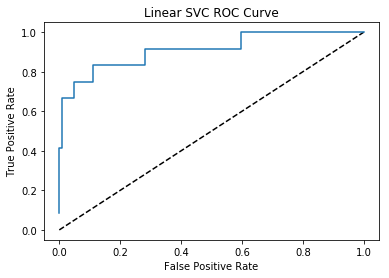

0.0 0.0833333333333
0.0 0.416666666667
0.00934579439252 0.416666666667
0.00934579439252 0.666666666667
0.0467289719626 0.666666666667
0.0467289719626 0.75
0.11214953271 0.75
0.11214953271 0.833333333333
0.280373831776 0.833333333333
0.280373831776 0.916666666667
0.598130841121 0.916666666667
0.598130841121 1.0
1.0 1.0


In [17]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.97      1.00      0.98        94
          1       1.00      0.88      0.94        25

avg / total       0.98      0.97      0.97       119


Confusion matrix, without normalization
[[94  0]
 [ 3 22]]

recall	0.88
precision	1.0
auc	0.94
specificity	1.0
npv	0.969072164948
accuracy	0.974789915966
weighted_sensitivity	0.88
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	0.892857142857
weighted_accuracy	0.94
TRAINNG PROBABILITIES
0 0.00439403097644
0 0.0322696113465
0 0.255872051262
0 0.0439150275119
0 0.119692861868
0 0.0675670924481
1 0.996698170316
0 0.00288832899151
0 0.201402944443
0 0.0424355117284
0 0.0631635906085
0 0.0111516096452
1 0.473470796509
0 0.0217648569465
1 0.054

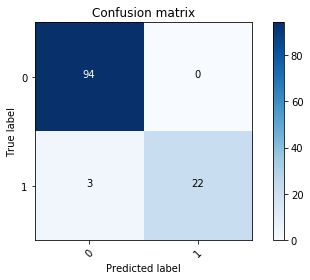

In [18]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [19]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0540019035339	0.00229758106945
score_time	0.030340385437	0.00200169978809
test_recall	0.808571428571	0.078558440485
train_recall	0.863052208835	0.0217906184197
test_precision	0.847455659609	0.102057803498
train_precision	0.914327994206	0.0316014940018
test_auc	0.8827001287	0.0506069011935
train_auc	0.920072605464	0.0132670906435
test_specificity	0.956828828829	0.0324687684341
train_specificity	0.977093002093	0.00912692919629
test_npv	0.946741057513	0.021890001647
train_npv	0.962195819184	0.00601538024084
test_accuracy	0.924318775663	0.0383614579759
train_accuracy	0.952117593758	0.00998024927455
test_weighted_sensitivity	0.808571428571	0.078558440485
train_weighted_sensitivity	0.863052208835	0.0217906184197
test_weighted_ppv	0.948519884974	0.038243556692
train_weighted_ppv	0.974143638422	0.010210659384
test_weighted_specificity	0.956828828829	0.0324687684341
train_weighted_specificity	0.977093002093	0.00912692919629
test_weighted_npv	0.836272782203	0.0606885915824
train_weigh

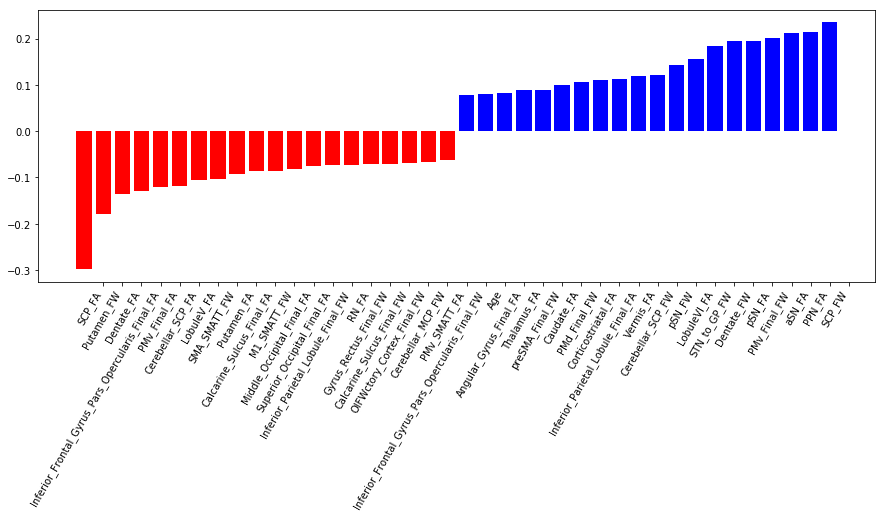

Age	0.0794986834111
Sex	0.0
aSN_FA	0.212561828367
Caudate_FA	0.100215626479
CC2_FA	0.0502714786542
GP_FA	-0.0493918914
LobuleVI_FA	0.155473364817
LobuleV_FA	-0.106224017978
MCP_FA	0.0359928624446
pSN_FA	0.194261128018
Putamen_FA	-0.0933584080043
SCP_FA	-0.298265685577
STN_FA	0.00595822105406
Thalamus_FA	0.0883693036097
Vermis_FA	0.118149299379
RN_FA	-0.0724547407549
PPN_FA	0.214903364375
Dentate_FA	-0.135271960019
CC1_FA	-0.0610574796994
aSN_FW	0.015988643368
Caudate_FW	0.0542084729532
CC2_FW	0.0481405896722
GP_FW	0.026680315492
LobuleVI_FW	0.00171859914405
LobuleV_FW	-0.0210268547319
MCP_FW	0.02864486265
pSN_FW	0.142417857777
Putamen_FW	-0.179310803307
SCP_FW	0.235307688769
STN_FW	0.0581202334645
Thalamus_FW	0.0214391142575
Vermis_FW	0.00788583688042
RN_FW	0.0232771624716
PPN_FW	0.0128191130447
Dentate_FW	0.194024305699
CC1_FW	-0.0263917276831
Angular_Gyrus_Final_FA	0.0824257996394
Anterior_Orbital_Gyrus_Final_FA	0.0396284093845
Calcarine_Sulcus_Final_FA	-0.0865311737079
Cuneus_Final_

In [20]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.97      1.00      0.98        94
          1       1.00      0.88      0.94        25

avg / total       0.98      0.97      0.97       119

TESTING PROBABILITIES
0 0.0172096537306
0 0.0100711654044
1 0.802197400504
0 0.0574983687546
1 0.0821505778122
0 0.00974782124606
0 0.0154152976025
0 0.018388566369
0 0.0186471388107
1 0.990099496867
0 0.00446011891039
0 0.163977736372
1 0.984232755874
0 0.0444708199328
0 0.0638325617147
0 0.0115619079314
1 0.708775818374
0 0.275798125761
0 0.0514634726014
1 0.984300142388
1 0.942324667516
0 0.0211473461097
0 0.0195945515533
0 0.053283734496
0 0.041357133439
0 0.0448410297871
1 0.987098552145
0 0.0102030867365
1 0.989001691212
0 0.0135719494889
0 0.088772099735
0 0.00711451893924
0 0.0395856555022
0 0.104110728053
1 0.702699243073
0 0.00739643422485
0 0.00966943645622
0 0.0752044551672
0 0.0145062181807
0 0.179184078307
1 0.49370977924
0 0.004378536522
0 0.0277296004672
1 0.

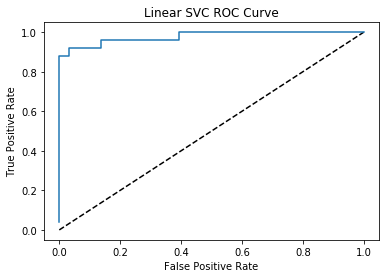

0.0 0.04
0.0 0.88
0.031914893617 0.88
0.031914893617 0.92
0.13829787234 0.92
0.13829787234 0.96
0.393617021277 0.96
0.393617021277 1.0
1.0 1.0


In [21]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    9.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.4s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.71      0.77      0.74        13
          1       0.90      0.87      0.88        30

avg / total       0.84      0.84      0.84        43


Confusion matrix, without normalization
[[10  3]
 [ 4 26]]

recall	0.866666666667
precision	0.896551724138
auc	0.817948717949
specificity	0.769230769231
npv	0.714285714286
accuracy	0.837209302326
weighted_sensitivity	0.866666666667
weighted_ppv	0.789719626168
weighted_specificity	0.769230769231
weighted_npv	0.852272727273
weighted_accuracy	0.817948717949
TRAINNG PROBABILITIES
1 0.603950847166
0 0.103070960881
0 0.802752262401
1 0.659272367343
1 0.987849192379
1 0.744318087628
1 0.394788185447
0 0.163890818181
1 0.924059594294
1 0.879401046336
1 

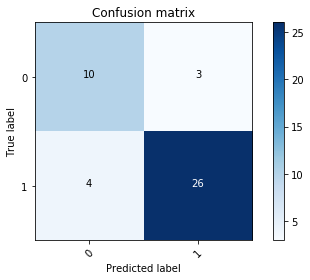

In [22]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [23]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0118061542511	0.00222192228481
score_time	0.0116006374359	0.00185210398121
test_recall	0.838947368421	0.0726506458574
train_recall	0.868639240506	0.0250140963303
test_precision	0.892084623323	0.0478124080463
train_precision	0.963684407096	0.0105473806589
test_auc	0.848521303258	0.0592701705933
train_auc	0.911449946068	0.0147717323098
test_specificity	0.858095238095	0.0649716491459
train_specificity	0.954260651629	0.0139430386423
test_npv	0.796240573152	0.0820284548142
train_npv	0.839761509442	0.0246528126105
test_accuracy	0.846671759613	0.0604853132473
train_accuracy	0.904431483867	0.0160050008251
test_weighted_sensitivity	0.838947368421	0.0726506458574
train_weighted_sensitivity	0.868639240506	0.0250140963303
test_weighted_ppv	0.856412501958	0.0622780610468
train_weighted_ppv	0.95011983536	0.0143531291526
test_weighted_specificity	0.858095238095	0.0649716491459
train_weighted_specificity	0.954260651629	0.0139430386423
test_weighted_npv	0.844134872471	0.0641219421202
train_w

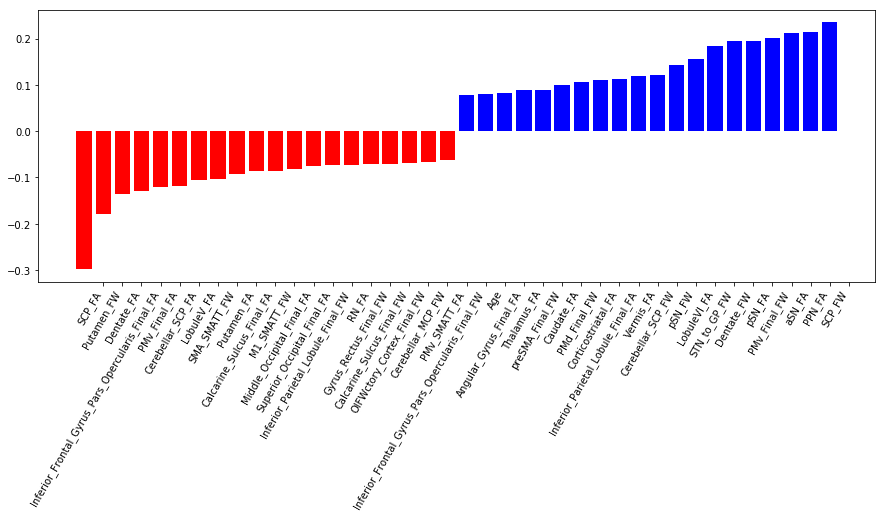

Age	0.0794986834111
Sex	0.0
aSN_FA	0.212561828367
Caudate_FA	0.100215626479
CC2_FA	0.0502714786542
GP_FA	-0.0493918914
LobuleVI_FA	0.155473364817
LobuleV_FA	-0.106224017978
MCP_FA	0.0359928624446
pSN_FA	0.194261128018
Putamen_FA	-0.0933584080043
SCP_FA	-0.298265685577
STN_FA	0.00595822105406
Thalamus_FA	0.0883693036097
Vermis_FA	0.118149299379
RN_FA	-0.0724547407549
PPN_FA	0.214903364375
Dentate_FA	-0.135271960019
CC1_FA	-0.0610574796994
aSN_FW	0.015988643368
Caudate_FW	0.0542084729532
CC2_FW	0.0481405896722
GP_FW	0.026680315492
LobuleVI_FW	0.00171859914405
LobuleV_FW	-0.0210268547319
MCP_FW	0.02864486265
pSN_FW	0.142417857777
Putamen_FW	-0.179310803307
SCP_FW	0.235307688769
STN_FW	0.0581202334645
Thalamus_FW	0.0214391142575
Vermis_FW	0.00788583688042
RN_FW	0.0232771624716
PPN_FW	0.0128191130447
Dentate_FW	0.194024305699
CC1_FW	-0.0263917276831
Angular_Gyrus_Final_FA	0.0824257996394
Anterior_Orbital_Gyrus_Final_FA	0.0396284093845
Calcarine_Sulcus_Final_FA	-0.0865311737079
Cuneus_Final_

In [24]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.71      0.77      0.74        13
          1       0.90      0.87      0.88        30

avg / total       0.84      0.84      0.84        43

TESTING PROBABILITIES
0 0.033221036543
1 0.986574681561
1 0.302113148145
0 0.78844396461
0 0.194125245101
1 0.987078820125
0 0.909603822754
0 0.231147240382
1 0.868663831122
1 0.719422880584
1 0.360107474623
1 0.935389119407
1 0.359888531672
0 0.770597646189
0 0.0782980650319
1 0.999997840351
1 0.278526794137
1 0.975057790758
1 0.981565358488
1 0.995396688465
0 0.35442853301
1 0.967638151929
1 0.900132486758
0 0.0909079208285
1 0.992799948835
1 0.983919589596
1 0.979130702007
1 0.923903420588
1 0.944787723022
1 0.922914656237
1 0.708014943335
0 0.0992431964128
1 0.628490041051
0 0.082550937895
1 0.953332786033
0 0.0531021122202
1 0.986847844145
1 0.957630243956
1 0.825342893744
1 0.91459224659
0 0.237437087059
1 0.887829841273
1 0.781827870159


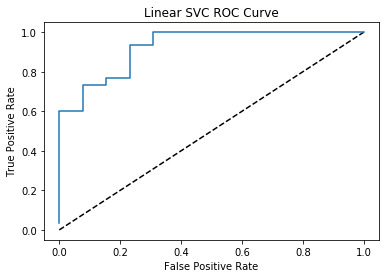

0.0 0.0333333333333
0.0 0.6
0.0769230769231 0.6
0.0769230769231 0.733333333333
0.153846153846 0.733333333333
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.933333333333
0.307692307692 0.933333333333
0.307692307692 1.0
1.0 1.0


In [25]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    8.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.90      0.87      0.88        30
          1       0.71      0.77      0.74        13

avg / total       0.84      0.84      0.84        43


Confusion matrix, without normalization
[[26  4]
 [ 3 10]]

recall	0.769230769231
precision	0.714285714286
auc	0.817948717949
specificity	0.866666666667
npv	0.896551724138
accuracy	0.837209302326
weighted_sensitivity	0.769230769231
weighted_ppv	0.852272727273
weighted_specificity	0.866666666667
weighted_npv	0.789719626168
weighted_accuracy	0.817948717949
TRAINNG PROBABILITIES
0 0.405237903463
1 0.876996603498
1 0.21702602871
0 0.354870360123
0 0.0181614689377
0 0.273390149584
0 0.596078503682
1 0.814075736968
0 0.0929874564895
0 0.140466043534
0

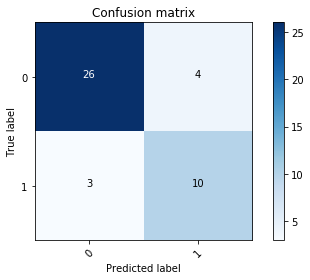

In [26]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [27]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0124006748199	0.00119157808059
score_time	0.0121078491211	0.00223711859752
test_recall	0.858095238095	0.0649716491459
train_recall	0.954260651629	0.0139430386423
test_precision	0.796240573152	0.0820284548142
train_precision	0.839761509442	0.0246528126105
test_auc	0.848521303258	0.0592701705933
train_auc	0.911449946068	0.0147717323098
test_specificity	0.838947368421	0.0726506458574
train_specificity	0.868639240506	0.0250140963303
test_npv	0.892084623323	0.0478124080463
train_npv	0.963684407096	0.0105473806589
test_accuracy	0.846671759613	0.0604853132473
train_accuracy	0.904431483867	0.0160050008251
test_weighted_sensitivity	0.858095238095	0.0649716491459
train_weighted_sensitivity	0.954260651629	0.0139430386423
test_weighted_ppv	0.844134872471	0.0641219421202
train_weighted_ppv	0.879423929019	0.0200337589256
test_weighted_specificity	0.838947368421	0.0726506458574
train_weighted_specificity	0.868639240506	0.0250140963303
test_weighted_npv	0.856412501958	0.0622780610468
train_

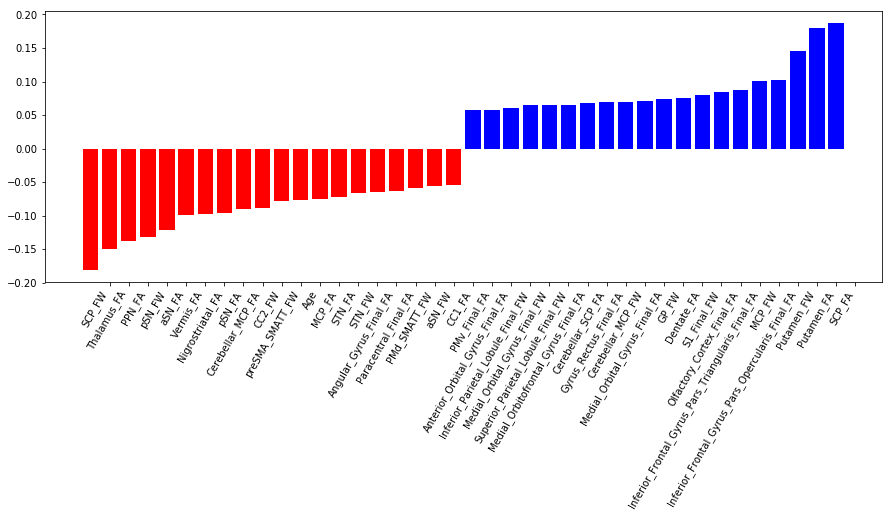

Age	-0.0762711786424
Sex	-0.0285537993012
aSN_FA	-0.121531014452
Caudate_FA	-0.0140960752737
CC2_FA	-0.0219530069555
GP_FA	0.0243216371045
LobuleVI_FA	-0.0505398831163
LobuleV_FA	0.0518825434615
MCP_FA	-0.0750181298434
pSN_FA	-0.0963781552945
Putamen_FA	0.18030770868
SCP_FA	0.187374017272
STN_FA	-0.0716912383312
Thalamus_FA	-0.15049514606
Vermis_FA	-0.0988966840541
RN_FA	0.0172331397306
PPN_FA	-0.138339538355
Dentate_FA	0.0757487307878
CC1_FA	-0.0546782776128
aSN_FW	-0.0565464200637
Caudate_FW	0.0104535471016
CC2_FW	-0.0887519151433
GP_FW	0.0733307269503
LobuleVI_FW	0.0123709855259
LobuleV_FW	0.0283790010115
MCP_FW	0.10057505347
pSN_FW	-0.132004271892
Putamen_FW	0.14547219721
SCP_FW	-0.181177531005
STN_FW	-0.0668286993803
Thalamus_FW	-0.0220822083985
Vermis_FW	0.00601272249054
RN_FW	-0.0495532015031
PPN_FW	-0.0448548528881
Dentate_FW	0.0435930425444
CC1_FW	-0.0140846183421
Angular_Gyrus_Final_FA	-0.064549986459
Anterior_Orbital_Gyrus_Final_FA	0.0575426096076
Calcarine_Sulcus_Final_FA	0

In [28]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.90      0.87      0.88        30
          1       0.71      0.77      0.74        13

avg / total       0.84      0.84      0.84        43

TESTING PROBABILITIES
1 0.956385452158
0 0.0198997190218
0 0.680684920128
1 0.230997082514
1 0.783883575905
0 0.0192345414167
1 0.109032880848
1 0.747802307998
0 0.151475014992
0 0.296968569243
0 0.630911098106
0 0.0805237464583
0 0.630636816333
1 0.248179411143
1 0.90367710143
0 0.0015997333888
0 0.702494151791
0 0.0351975745489
0 0.0266514018894
0 0.00747822138898
1 0.636670769224
0 0.044799087219
0 0.118711544116
1 0.889774886172
0 0.011244329923
0 0.023508161709
0 0.0298688709927
0 0.093236057536
0 0.069931369639
0 0.0942299217879
0 0.30757911244
1 0.881023550111
0 0.384434873199
1 0.898825903585
0 0.060139901954
1 0.934317815549
0 0.0195370968114
0 0.0575039277237
0 0.194903255866
0 0.103310125345
1 0.741823217652
0 0.131609677775
0 0.237385905777


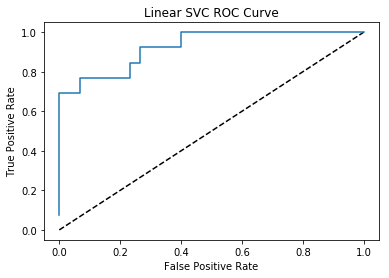

0.0 0.0769230769231
0.0 0.692307692308
0.0666666666667 0.692307692308
0.0666666666667 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.266666666667 0.846153846154
0.266666666667 0.923076923077
0.4 0.923076923077
0.4 1.0
1.0 1.0


In [29]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)

In [30]:
import pickle
mod_name = 'no-updrs'
pickle.dump(best1, open('./models/%s/park_v_control.pkl' %mod_name, 'wb'))
pickle.dump(best2, open('./models/%s/pd_v_atypical.pkl' %mod_name, 'wb'))
pickle.dump(best3, open('./models/%s/msa_v_pd_psp.pkl' %mod_name, 'wb'))
pickle.dump(best4, open('./models/%s/psp_v_pd_msa.pkl' %mod_name, 'wb'))
pickle.dump(best5, open('./models/%s/psp_v_msa.pkl' %mod_name, 'wb'))